In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import os
from pathlib import Path

In [21]:
import numpy as np
import scipy.ndimage
from skimage.filters import threshold_otsu
from skimage.util import view_as_windows

def compute_local_entropy(image, window_size=5):
    """
    Computes the local entropy for each pixel in a grayscale image.
    
    Parameters:
        image (2D numpy array): The input image (values between 0 and 1).
        window_size (int): Size of the sliding window.
        
    Returns:
        entropy_map (2D numpy array): Local entropy values for each pixel.
    """
    # Ensure the window size is odd
    if window_size % 2 == 0:
        window_size += 1

    # Ensure the image is a floating-point numpy array
    image = np.asarray(image, dtype=np.float32)
    
    # Define an entropy function for a window
    def entropy(window):
        hist, _ = np.histogram(window, bins=10, range=(0, 1), density=True)
        hist = hist[hist > 0]  # Remove zero values
        return -np.sum(hist * np.log2(hist)) if hist.size > 0 else 0  # Shannon entropy formula

    # Apply the entropy function using a moving window
    entropy_map = scipy.ndimage.generic_filter(image, entropy, size=window_size)
    
    return entropy_map

def entropy_based_binarization(image, window_size=5):
    """
    Converts an image into a binary map using local entropy.
    
    Parameters:
        image (2D numpy array): Input grayscale image.
        window_size (int): Size of the window for entropy computation.
    
    Returns:
        binary_map (2D numpy array): Binary map (1 = clustered, 0 = dispersed).
    """
    # Compute local entropy
    entropy_map = compute_local_entropy(image, window_size)

    # Use Otsu's method to find a threshold for entropy
    threshold = threshold_otsu(entropy_map)

    # Create binary map (low entropy = clustered = 1, high entropy = dispersed = 0)
    binary_map = (entropy_map < threshold).astype(int)
    
    return binary_map





In [55]:
uq_path = Path("C:/Users/cwinklm/Documents/Data/uncertainty_arctique_v1-0-corrected_14/UQ_maps")
all_uq = os.listdir(uq_path)

task = "instance"
model_noise = 0
variation = "nuclei_intensity"
data_noise = "1_00"
uq_method = "ensemble"
decomp = "PU"

map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise}_{uq_method}_{decomp}.npy"
uq_maps = np.load(uq_path.joinpath(map_type))

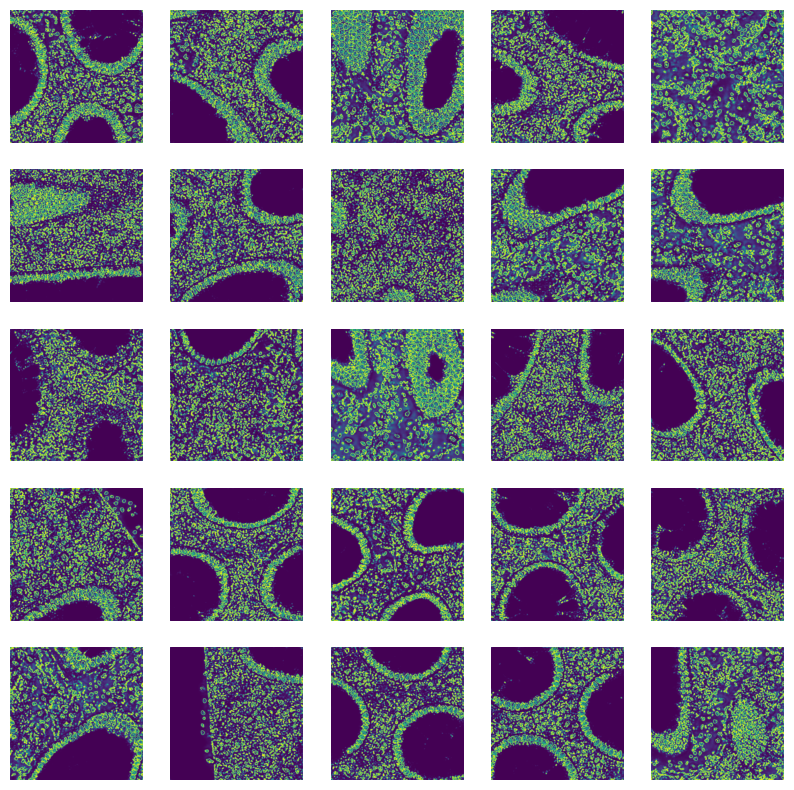

In [56]:
plt.figure(figsize=(10, 10))

for i  in range(25):

    plt.subplot(5,5,i+1)
    plt.imshow(uq_maps[i, :, :])
    plt.axis('off')

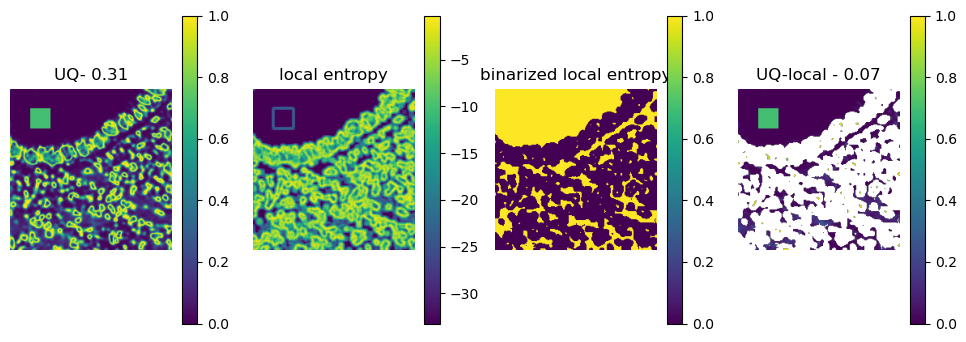

In [59]:
mini_uq = uq_maps[25, :200, :200]
#mini_uq[25:50, 25:50] = 0.7
H_mini = compute_local_entropy(mini_uq)
H_bin = entropy_based_binarization(mini_uq)



plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(mini_uq)
plt.axis("off")
plt.title(f"UQ- {np.mean(mini_uq):.2f}")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(H_mini)
plt.axis("off")
plt.title("local entropy")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(H_bin)
plt.axis("off")
plt.title("binarized local entropy")
plt.colorbar()

local_mini_uq = np.ma.masked_array(mini_uq, H_bin==0)    #np.multiply(mini_uq, H_bin)
plt.subplot(1, 4, 4)
plt.imshow(local_mini_uq)
plt.axis("off")
plt.title(f"UQ-local - {np.mean(local_mini_uq):.2f}")
plt.colorbar()

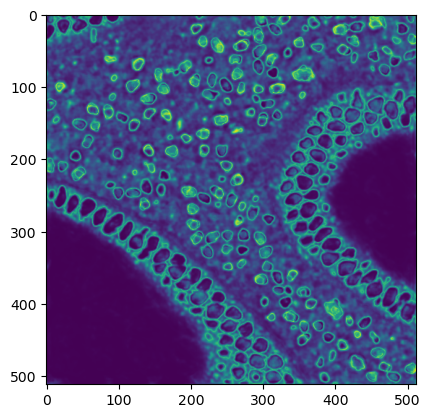

In [6]:
plt.imshow(uq_maps[1, :, :])



In [ ]:
mini_uq = uq_maps[0, :100, :100]
plt.imshow(mini_uq)

[1, 2, 3, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6]


[array([0.5386], dtype=float16)] 0.5386
[array([0.5386, 0.2206], dtype=float16)] 0.2206


c:\Users\cwinklm\.local\share\mamba\envs\work_env\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cwinklm\.local\share\mamba\envs\work_env\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [36]:
x_len, y_len = mini_uq.shape
neigh_map = np.zeros((x_len, y_len))

for x in range(x_len): 
    for y in range(y_len): 
        val =  mini_uq[x, y]
        neighbors = list(mini_uq[max(0, x-1):(min(x+1, x_len)+1), max(0, y-1):(min(y+1, y_len)+1)].flatten())
        #print(max(0, x-1), min(x+1, x_len)+1, max(0, y-1), min(y+1, y_len)+1)
        #print("neight", neighbors)
        #print("val", val)
        neighbors.remove(val)

        if abs(val-np.mean(neighbors)) <.01: 
            neigh_map[x, y] = 1
        else: 
            neigh_map[x, y] = 0

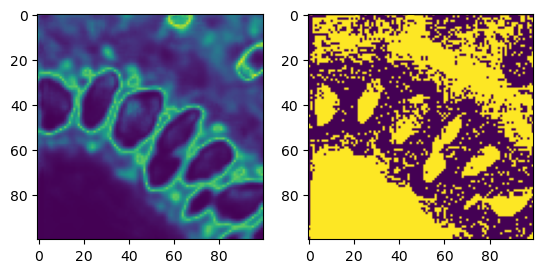

In [37]:

plt.subplot(121)
plt.imshow(mini_uq)

plt.subplot(122)
plt.imshow(neigh_map)